In [10]:
# .\venv_vietlott\Scripts\Activate.ps1

In [11]:
! pip install pandas catboost requests  seaborn  selenium matplotlib  tensorflow numpy scikit-learn xgboost lightgbm tensorflow-addons optuna imbalanced-learn


In [12]:
import pandas as pd
import json
import os

# Đường dẫn tệp
INPUT_FILE = r"E:\vietlot_mega\data_655\vietlott_655_processed.csv"
OUTPUT_FILE = r"E:\vietlot_mega\data_655\vietlott_655_clean.csv"
DATA_DIR = r"E:\vietlot_mega\data_655"

# Tạo thư mục nếu chưa tồn tại
os.makedirs(DATA_DIR, exist_ok=True)

# Đọc dữ liệu với dấu phân cách tab
try:
    df = pd.read_csv(INPUT_FILE, encoding="utf-8-sig", sep='\t')
except Exception as e:
    raise Exception(f"Lỗi khi đọc file {INPUT_FILE}: {e}")

# In danh sách cột để kiểm tra
print("Các cột trong tệp CSV:", df.columns.tolist())

# Hàm xử lý cột ngày
def process_date(date_str):
    # Loại bỏ tiền tố ngày trong tuần (nếu có, ví dụ: 'T3, ')
    if ", " in str(date_str):
        date_str = date_str.split(", ")[-1]
    return pd.to_datetime(date_str, format="%d/%m/%Y", dayfirst=True, errors='coerce')

# Hàm xử lý cột 'Kết Quả'
def process_result(result_str):
    # Chuyển chuỗi thành danh sách số
    numbers = [int(x) for x in str(result_str).split()]
    # Lấy 6 số chính (bỏ số bổ sung)
    return numbers[:6]

# Xử lý dữ liệu
# Tìm cột ngày (linh hoạt với các tên cột phổ biến)
date_column = None
possible_date_columns = ['Ngày Mở Thưởng', 'Ngay Mo Thuong', 'Date', 'Ngày', 'Draw Date']
for col in possible_date_columns:
    if col in df.columns:
        date_column = col
        break

if date_column is None:
    raise KeyError("Không tìm thấy cột ngày trong CSV. Các cột hiện có: " + str(df.columns.tolist()))

# Kiểm tra cột 'Kết Quả'
if 'Kết Quả' not in df.columns:
    possible_result_columns = ['Ket Qua', 'Result', 'Kết quả']
    for col in possible_result_columns:
        if col in df.columns:
            df = df.rename(columns={col: 'Kết Quả'})
            break
    else:
        raise KeyError("Không tìm thấy cột 'Kết Quả' trong CSV. Các cột hiện có: " + str(df.columns.tolist()))

# Làm sạch tên cột (loại bỏ khoảng trắng thừa)
df.columns = df.columns.str.strip()

# Áp dụng xử lý
df['Ngày'] = df[date_column].apply(process_date)
df['Kết Quả'] = df['Kết Quả'].apply(process_result)

# Kiểm tra giá trị ngày không hợp lệ
invalid_dates = df[df['Ngày'].isna()]
if not invalid_dates.empty:
    raise ValueError(f"Có {len(invalid_dates)} giá trị ngày không hợp lệ:\n" + str(invalid_dates[[date_column, 'Kết Quả']]))

# Kiểm tra tính hợp lệ của kết quả
def validate_result(result):
    try:
        if len(result) != 6:
            return False, "Phải có đúng 6 số chính"
        if not all(isinstance(x, int) and 1 <= x <= 55 for x in result):
            return False, "Số phải trong khoảng 1-55"
        return True, ""
    except:
        return False, "Định dạng không hợp lệ"

df['Valid_Result'] = df['Kết Quả'].apply(validate_result)
invalid_results = df[~df['Valid_Result'].apply(lambda x: x[0])]
if not invalid_results.empty:
    raise ValueError("Dữ liệu chứa kết quả không hợp lệ:\n" + str(invalid_results[['Ngày', 'Kết Quả', 'Valid_Result']]))

# Chuyển danh sách Kết Quả thành chuỗi JSON để lưu
df['Kết Quả'] = df['Kết Quả'].apply(json.dumps)

# Lưu dữ liệu đã xử lý
df[['Ngày', 'Kết Quả']].to_csv(OUTPUT_FILE, index=False, encoding="utf-8-sig")
print(f"Đã lưu dữ liệu đã xử lý vào: {OUTPUT_FILE}")

Các cột trong tệp CSV: ['Ngày Mở Thưởng', 'Kết Quả', 'Giải Jackpot 1', 'Giải Jackpot 2']
Đã lưu dữ liệu đã xử lý vào: E:\vietlot_mega\data_655\vietlott_655_clean.csv


## Phân tích tần suất + Phân tích cặp số + Phân tích chuỗi thời gian + Kiểm tra phân phối:

Top 5 số xuất hiện nhiều nhất:
1    139
2    117
3    140
4    112
5    129
Name: count, dtype: int64

Top 5 số xuất hiện ít nhất:
51    153
52    133
53    136
54    125
55    131
Name: count, dtype: int64


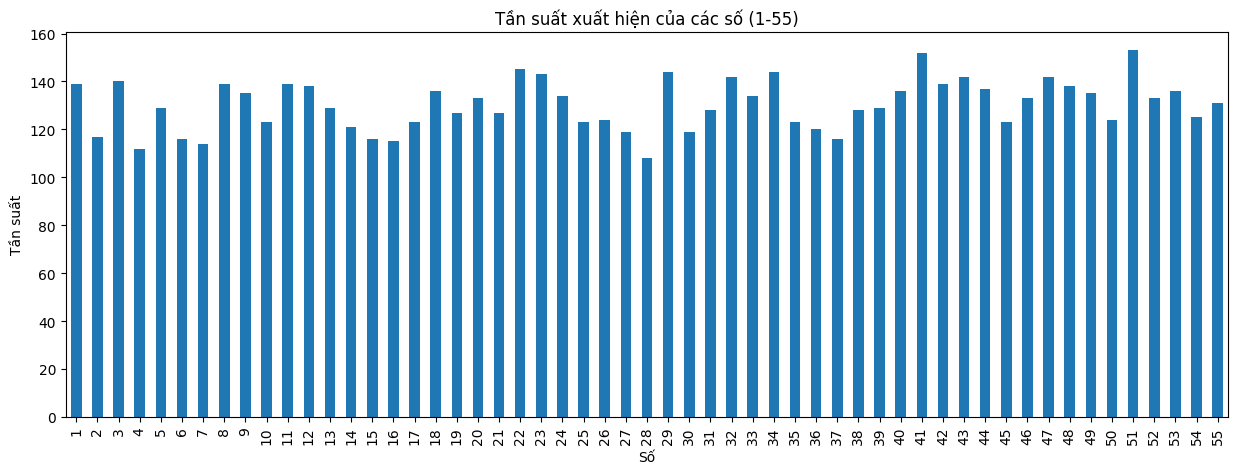


Top 5 cặp số xuất hiện nhiều nhất:
Cặp (3, 41): 26 lần
Cặp (9, 54): 25 lần
Cặp (42, 51): 25 lần
Cặp (32, 51): 24 lần
Cặp (12, 44): 23 lần


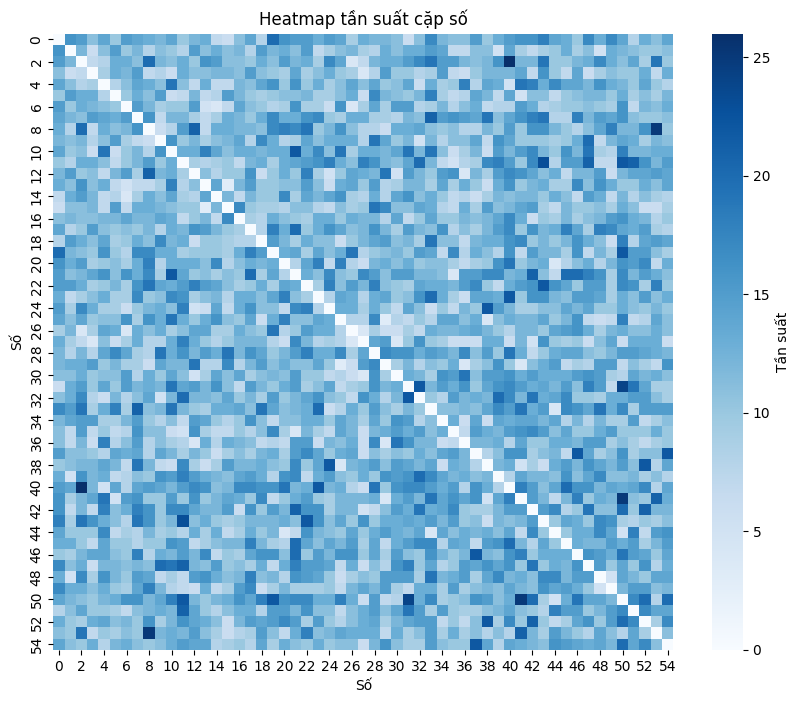

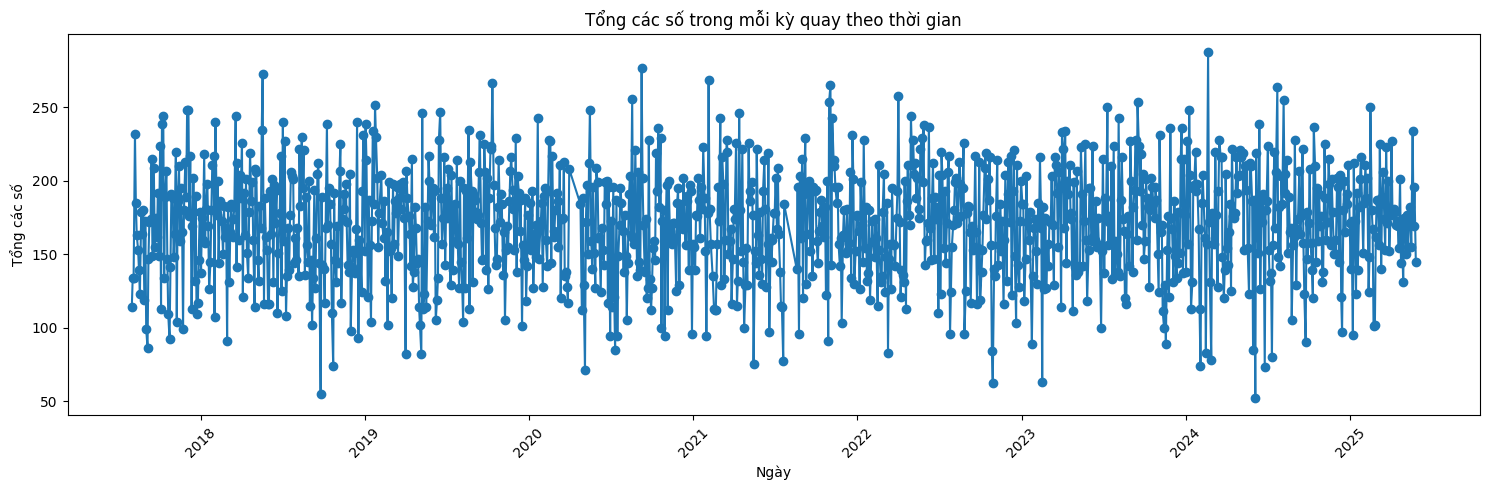


Tần suất số trong 10 kỳ gần nhất:
2     1
3     2
4     1
6     1
7     3
8     1
9     2
12    2
13    1
14    2
Name: count, dtype: int64

Kiểm tra phân phối (Kolmogorov-Smirnov test):
KS Statistic: 0.0194, p-value: 0.0090
Dữ liệu không hoàn toàn tuân theo phân phối đều.


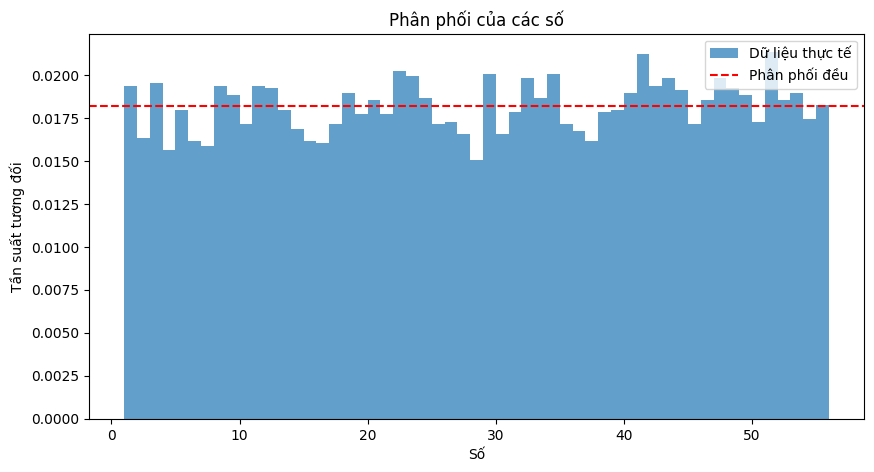


Bộ số gợi ý cho kỳ quay ngày 04/06/2025:
[1, 2, 3, 4, 21, 31]


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from scipy.stats import kstest, uniform
from collections import Counter
import seaborn as sns

# Đọc dữ liệu từ file CSV
df = pd.read_csv("E:/vietlot_mega/data_655/vietlott_655_clean.csv")

# Chuyển đổi cột 'Kết Quả' từ chuỗi sang danh sách số
df['Kết Quả'] = df['Kết Quả'].apply(eval)

# Chuyển đổi cột 'Ngày' sang định dạng datetime
df['Ngày'] = pd.to_datetime(df['Ngày'])

# 1. PHÂN TÍCH TẦN SUẤT
# Tạo danh sách tất cả các số đã xuất hiện
all_numbers = np.concatenate(df['Kết Quả'].values)

# Tính tần suất xuất hiện của mỗi số
freq = pd.Series(all_numbers).value_counts().sort_index()

# Hiển thị top 5 số xuất hiện nhiều nhất và ít nhất
print("Top 5 số xuất hiện nhiều nhất:")
print(freq.head(5))
print("\nTop 5 số xuất hiện ít nhất:")
print(freq.tail(5))

# Vẽ biểu đồ tần suất
plt.figure(figsize=(15, 5))
freq.plot(kind='bar')
plt.title("Tần suất xuất hiện của các số (1-55)")
plt.xlabel("Số")
plt.ylabel("Tần suất")
plt.show()

# 2. PHÂN TÍCH CẶP SỐ
# Tạo tất cả các cặp số từ mỗi kỳ quay
pairs = []
for result in df['Kết Quả']:
    pairs.extend(list(combinations(sorted(result), 2)))

# Đếm tần suất các cặp số
pair_counts = Counter(pairs)
most_common_pairs = pair_counts.most_common(5)

# Hiển thị các cặp số xuất hiện nhiều nhất
print("\nTop 5 cặp số xuất hiện nhiều nhất:")
for pair, count in most_common_pairs:
    print(f"Cặp {pair}: {count} lần")

# Vẽ heatmap cho tần suất cặp số
pair_matrix = np.zeros((56, 56))  # Ma trận 56x56 (1-55)
for (i, j), count in pair_counts.items():
    pair_matrix[i, j] = count
    pair_matrix[j, i] = count

plt.figure(figsize=(10, 8))
sns.heatmap(pair_matrix[1:, 1:], cmap='Blues', cbar_kws={'label': 'Tần suất'})
plt.title("Heatmap tần suất cặp số")
plt.xlabel("Số")
plt.ylabel("Số")
plt.show()

# 3. PHÂN TÍCH CHUỖI THỜI GIAN
# Tính tổng các số trong mỗi kỳ quay
df['Tổng'] = df['Kết Quả'].apply(sum)

# Vẽ biểu đồ tổng theo thời gian
plt.figure(figsize=(15, 5))
plt.plot(df['Ngày'], df['Tổng'], marker='o')
plt.title("Tổng các số trong mỗi kỳ quay theo thời gian")
plt.xlabel("Ngày")
plt.ylabel("Tổng các số")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Phân tích số xuất hiện trong 10 kỳ gần nhất
recent_10 = df.head(10)
recent_numbers = np.concatenate(recent_10['Kết Quả'].values)
recent_freq = pd.Series(recent_numbers).value_counts().sort_index()
print("\nTần suất số trong 10 kỳ gần nhất:")
print(recent_freq.head(10))

# 4. KIỂM TRA PHÂN PHỐI
# Kiểm tra xem các số có tuân theo phân phối đều (uniform) hay không
ks_stat, p_value = kstest(all_numbers, 'uniform', args=(1, 55))
print("\nKiểm tra phân phối (Kolmogorov-Smirnov test):")
print(f"KS Statistic: {ks_stat:.4f}, p-value: {p_value:.4f}")
if p_value > 0.05:
    print("Dữ liệu có vẻ tuân theo phân phối đều (ngẫu nhiên).")
else:
    print("Dữ liệu không hoàn toàn tuân theo phân phối đều.")

# Vẽ histogram để kiểm tra phân phối
plt.figure(figsize=(10, 5))
plt.hist(all_numbers, bins=55, range=(1, 56), density=True, alpha=0.7, label='Dữ liệu thực tế')
plt.axhline(y=1/55, color='r', linestyle='--', label='Phân phối đều')
plt.title("Phân phối của các số")
plt.xlabel("Số")
plt.ylabel("Tần suất tương đối")
plt.legend()
plt.show()

# 5. GỢI Ý BỘ SỐ CHO KỲ QUAY TIẾP THEO
# Chọn 4 số từ top tần suất và 2 số ngẫu nhiên từ các số còn lại
top_numbers = freq.head(4).index.tolist()
remaining_numbers = list(set(range(1, 56)) - set(top_numbers))
random_numbers = np.random.choice(remaining_numbers, 2, replace=False).tolist()
suggested_numbers = sorted(top_numbers + random_numbers)

print("\nBộ số gợi ý cho kỳ quay ngày 04/06/2025:")
print(suggested_numbers)

## LSTM + KNN + TRANS +  Logistic Regression + Chọn số dựa trên tần suất + Kết hợp số nóng và lạnh

In [ ]:
import pandas as pd
import numpy as np
from ast import literal_eval
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, LayerNormalization, MultiHeadAttention, Input, LSTM, GRU, Concatenate, Flatten, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, Callback, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.regularizers import l2
import tensorflow as tf
import random
from collections import Counter
from datetime import datetime, timedelta
import os
import logging
import json
import yaml
import itertools
from tqdm import tqdm
import warnings

warnings.filterwarnings('ignore')

# Thiết lập logging
logging.basicConfig(level=logging.INFO, format='%(message)s')

def log_structured(message, level='INFO', **kwargs):
    log_entry = {'level': level, 'message': message, 'timestamp': datetime.now().isoformat(), **kwargs}
    logging.log(getattr(logging, level), json.dumps(log_entry, ensure_ascii=False))

# Thiết lập seed
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

# Tải cấu hình
def load_config(config_path='config.yaml'):
    try:
        with open(config_path, 'r', encoding='utf-8') as f:
            return yaml.safe_load(f)
    except FileNotFoundError:
        log_structured(f"Tệp cấu hình {config_path} không tồn tại, sử dụng cấu hình mặc định.", level='WARNING')
        return {
            'model': {
                'num_heads': 8,
                'ff_dim': 256,
                'learning_rate': 0.0005,
                'batch_size': 32,
                'epochs': 100,  # Giảm để tăng tốc
                'dropout_rate': 0.2,
                'hist_ratio': 0.4
            },
            'data': {
                'file_path': 'E:\\vietlot_mega\\data_655\\vietlott_655_clean.csv',
                'sequence_length': 30
            }
        }

CONFIG = load_config()

# Callback ghi log huấn luyện
class PrintTrainingMetrics(Callback):
    def on_epoch_end(self, epoch, logs=None):
        log_structured(
            f"Epoch {epoch+1}/{self.params['epochs']}",
            level='INFO',
            loss=logs['loss'],
            val_loss=logs['val_loss'],
            precision_at_k=logs.get('precision_at_k', 0),
            val_precision_at_k=logs.get('val_precision_at_k', 0),
            recall_at_k=logs.get('recall_at_k', 0),
            val_recall_at_k=logs.get('val_recall_at_k', 0)
        )

class StatisticalAnalyzer:
    def __init__(self, results):
        self.results = results
        self.patterns = {}

    def compute_patterns(self):
        all_numbers = [num for draw in self.results for num in draw]
        freq = Counter(all_numbers)
        total_draws = len(self.results)
        self.patterns['frequencies'] = {int(k): v for k, v in freq.items()}
        self.patterns['number_probabilities'] = {int(k): v / (total_draws * 6) for k, v in freq.items()}
        self.patterns['candidate_numbers'] = sorted(freq, key=freq.get, reverse=True)[:25] or list(range(1, 56))
        recent_numbers = [num for draw in self.results[-20:] for num in draw]
        recent_freq = Counter(recent_numbers)
        self.patterns['recent_frequencies'] = {int(k): v / 120 for k, v in recent_freq.items()}
        self.patterns['recent_top_10'] = sorted(recent_freq, key=recent_freq.get, reverse=True)[:12]
        self.patterns['hot_numbers'] = sorted(recent_freq, key=recent_freq.get, reverse=True)[:8]
        self.patterns['cold_numbers'] = sorted(freq, key=freq.get)[:5]
        pair_counts = Counter()
        for draw in self.results:
            for pair in itertools.combinations(sorted(draw), 2):
                pair_counts[pair] += 1
        self.patterns['pair_probabilities'] = {f"{k[0]}-{k[1]}": v / total_draws for k, v in pair_counts.items()}
        last_appearance = {}
        for i, draw in enumerate(self.results[::-1]):
            for num in draw:
                if num not in last_appearance:
                    last_appearance[num] = i
        self.patterns['last_appearance'] = last_appearance
        recent_momentum = {num: sum(1 for draw in self.results[-5:] if num in draw) / 5 for num in range(1, 56)}
        self.patterns['recent_momentum'] = recent_momentum
        log_structured("Đã tính toán các mẫu thống kê.", level='DEBUG', patterns={k: v for k, v in self.patterns.items() if k != 'pair_probabilities'})
        return self.patterns

class VietlottPredictor:
    def __init__(self, config=CONFIG):
        self.sequence_length = config['data']['sequence_length']
        self.file_path = config['data']['file_path']
        self.config = config['model']
        self.results = None
        self.df = None
        self.scaler = None
        self.feature_scaler = None
        self.X_train, self.X_test, self.y_train, self.y_test = None, None, None, None
        self.X_train_rf, self.X_test_rf, self.y_train_rf, self.y_test_rf = None, None, None, None
        self.last_sequence = None
        self.last_sequence_rf = None
        self.statistical_patterns = {}
        self.next_draw = None
        self.next_date = None
        self.rf_model = None
        self.knn_model = None
        self.logreg_models = None
        self.constraints = None

    def get_next_draw(self, steps_ahead=1):
        if self.df is None or self.df.empty:
            raise ValueError("Dữ liệu chưa được tải.")
        log_structured("Xác định kỳ quay và ngày diễn ra tiếp theo...", level='INFO')
        self.df['Draw'] = range(1, len(self.df) + 1)
        last_draw = self.df['Draw'].iloc[-1]
        last_date = self.df['Date'].iloc[-1]
        log_structured(f"Ngày cuối trong dữ liệu: {last_date.strftime('%Y-%m-%d')} (Thứ {last_date.weekday()+1})", level='INFO')
        target_days = [1, 3, 5]  # Thứ Ba, Năm, Bảy
        current_date = last_date
        for _ in range(steps_ahead):
            current_day = current_date.weekday()
            days_ahead = min((target - current_day) % 7 or 7 for target in target_days)
            current_date += timedelta(days=days_ahead)
        self.next_date = current_date
        self.next_draw = last_draw + steps_ahead
        log_structured(f"Kỳ quay tiếp theo: {self.next_draw}, Ngày: {self.next_date.strftime('%Y-%m-%d')}", level='INFO')
        return self.next_draw, self.next_date

    def compute_dynamic_constraints(self):
        sums = self.df['Sum'].apply(np.expm1)
        odd_counts = self.df['OddCount']
        self.constraints = {
            'sum_min': sums.quantile(0.1),
            'sum_max': sums.quantile(0.9) * 1.15,  # Nới lỏng thêm để giảm fallback
            'odd_count': Counter(odd_counts).most_common(1)[0][0]
        }
        log_structured("Đã tính toán các ràng buộc động.", level='INFO', constraints=self.constraints)

    def load_and_preprocess_data(self):
        log_structured("Đang tải và tiền xử lý dữ liệu...", level='INFO')
        try:
            if not os.path.exists(self.file_path):
                raise FileNotFoundError(f"File không tồn tại: {self.file_path}")
            self.df = pd.read_csv(self.file_path, encoding='utf-8')
            if 'Ngày' not in self.df.columns or 'Kết Quả' not in self.df.columns:
                raise ValueError("CSV phải có cột 'Ngày' và 'Kết Quả'")
            self.df['Numbers'] = self.df['Kết Quả'].apply(literal_eval)
            self.df = self.df.dropna(subset=['Numbers'])
            for idx, draw in enumerate(self.df['Numbers']):
                if not isinstance(draw, list) or len(set(draw)) != 6 or any(not isinstance(n, int) or n < 1 or n > 55 for n in draw):
                    raise ValueError(f"Kỳ quay không hợp lệ tại dòng {idx}: {draw}")
            self.df['Date'] = pd.to_datetime(self.df['Ngày'], format='%Y-%m-%d', errors='coerce')
            self.df = self.df.dropna(subset=['Date']).sort_values('Date')
            self.results = self.df['Numbers'].tolist()
            analyzer = StatisticalAnalyzer(self.results)
            self.statistical_patterns = analyzer.compute_patterns()
            self.df['OddCount'] = self.df['Numbers'].apply(lambda x: sum(1 for n in x if n % 2 == 1))
            self.df['Sum'] = self.df['Numbers'].apply(lambda x: np.log1p(sum(x)))
            self.df['Range'] = self.df['Numbers'].apply(lambda x: np.log1p(max(x) - min(x)))
            self.df['ClusterCount'] = self.df['Numbers'].apply(lambda x: sum(1 for n in x if 1 <= n <= 18) / 6 + sum(1 for n in x if 19 <= n <= 36) / 6 + sum(1 for n in x if 37 <= n <= 55) / 6)
            self.df['RecentFreq'] = self.df['Numbers'].apply(lambda x: sum(self.statistical_patterns['recent_frequencies'].get(n, 0) for n in x))
            self.df['ConsecutiveCount'] = self.df['Numbers'].apply(lambda x: sum(1 for i in range(len(x)-1) if sorted(x)[i+1] == sorted(x)[i] + 1))
            self.df['DeltaSum'] = self.df['Sum'].diff().fillna(0)
            self.df['NumberGaps'] = self.df['Numbers'].apply(lambda x: np.mean([sorted(x)[i+1] - sorted(x)[i] for i in range(len(x)-1)]))
            self.df['RecentHotSpot'] = self.df['Numbers'].apply(lambda x: sum(1 for n in x if n in [num for draw in self.results[-5:] for num in draw]) / 6)
            self.df['PatternScore'] = self.df['Numbers'].apply(lambda x: sum(self.statistical_patterns['pair_probabilities'].get(f"{min(a,b)}-{max(a,b)}", 0) for a, b in itertools.combinations(x, 2)))
            self.df['LastAppearance'] = self.df['Numbers'].apply(lambda x: np.mean([self.statistical_patterns['last_appearance'].get(n, len(self.results)) for n in x]))
            self.df['RecentMomentum'] = self.df['Numbers'].apply(lambda x: np.mean([self.statistical_patterns['recent_momentum'].get(n, 0) for n in x]))
            self.compute_dynamic_constraints()
            log_structured(f"Dữ liệu đã được tải và tiền xử lý thành công. Số kỳ: {len(self.df)}", level='INFO')
        except Exception as e:
            log_structured(f"Lỗi khi tải dữ liệu: {str(e)}", level='ERROR')
            raise

    def prepare_sequences(self):
        log_structured("Chuẩn bị chuỗi dữ liệu...", level='INFO')
        try:
            sequences = []
            targets = []
            features = []
            for i in range(len(self.results) - self.sequence_length):
                seq = self.results[i:i + self.sequence_length]
                target = self.results[i + self.sequence_length]
                seq_features = [
                    self.df['OddCount'].iloc[i:i + self.sequence_length].values,
                    self.df['Sum'].iloc[i:i + self.sequence_length].values,
                    self.df['Range'].iloc[i:i + self.sequence_length].values,
                    self.df['ClusterCount'].iloc[i:i + self.sequence_length].values,
                    self.df['RecentFreq'].iloc[i:i + self.sequence_length].values,
                    self.df['ConsecutiveCount'].iloc[i:i + self.sequence_length].values,
                    self.df['DeltaSum'].iloc[i:i + self.sequence_length].values,
                    self.df['NumberGaps'].iloc[i:i + self.sequence_length].values,
                    self.df['RecentHotSpot'].iloc[i:i + self.sequence_length].values,
                    self.df['PatternScore'].iloc[i:i + self.sequence_length].values,
                    self.df['LastAppearance'].iloc[i:i + self.sequence_length].values,
                    self.df['RecentMomentum'].iloc[i:i + self.sequence_length].values
                ]
                sequences.append(seq)
                targets.append(target)
                features.append(np.stack(seq_features, axis=-1))
            X = np.array(sequences)
            X_features = np.array(features)
            y = np.array(targets)
            self.scaler = MinMaxScaler(feature_range=(0, 1))
            X_reshaped = X.reshape(-1, X.shape[-1])
            X_scaled = self.scaler.fit_transform(X_reshaped)
            X = X_scaled.reshape(X.shape)
            self.feature_scaler = MinMaxScaler(feature_range=(0, 1))
            X_features_reshaped = X_features.reshape(-1, X_features.shape[-1])
            X_features_scaled = self.feature_scaler.fit_transform(X_features_reshaped)
            X_features = X_features_scaled.reshape(X_features.shape)
            X = np.concatenate([X, X_features], axis=-1)
            from sklearn.model_selection import train_test_split
            self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
                X, y, test_size=0.1, random_state=RANDOM_SEED, shuffle=False
            )
            last_sequence = np.array(self.results[-self.sequence_length:])
            last_features = np.stack([
                self.df['OddCount'].iloc[-self.sequence_length:].values,
                self.df['Sum'].iloc[-self.sequence_length:].values,
                self.df['Range'].iloc[-self.sequence_length:].values,
                self.df['ClusterCount'].iloc[-self.sequence_length:].values,
                self.df['RecentFreq'].iloc[-self.sequence_length:].values,
                self.df['ConsecutiveCount'].iloc[-self.sequence_length:].values,
                self.df['DeltaSum'].iloc[-self.sequence_length:].values,
                self.df['NumberGaps'].iloc[-self.sequence_length:].values,
                self.df['RecentHotSpot'].iloc[-self.sequence_length:].values,
                self.df['PatternScore'].iloc[-self.sequence_length:].values,
                self.df['LastAppearance'].iloc[-self.sequence_length:].values,
                self.df['RecentMomentum'].iloc[-self.sequence_length:].values
            ], axis=-1)
            last_sequence_reshaped = last_sequence.reshape(-1, last_sequence.shape[-1])
            last_sequence_scaled = self.scaler.transform(last_sequence_reshaped).reshape(1, self.sequence_length, 6)
            last_features_reshaped = last_features.reshape(-1, last_features.shape[-1])
            last_features_scaled = self.feature_scaler.transform(last_features_reshaped).reshape(1, self.sequence_length, 12)
            self.last_sequence = np.concatenate([last_sequence_scaled, last_features_scaled], axis=-1)
        except Exception as e:
            log_structured(f"Lỗi khi chuẩn bị chuỗi: {str(e)}", level='ERROR')
            raise

    def prepare_data_for_rf_knn_logreg(self):
        log_structured("Chuẩn bị dữ liệu cho Random Forest, KNN, Logistic Regression...", level='INFO')
        try:
            sequences = []
            targets = []
            for i in range(len(self.results) - self.sequence_length):
                seq = self.results[i:i + self.sequence_length]
                target = self.results[i + self.sequence_length]
                seq_flat = np.array(seq).flatten()
                features = [
                    self.df['OddCount'].iloc[i + self.sequence_length - 1],
                    self.df['Sum'].iloc[i + self.sequence_length - 1],
                    self.df['Range'].iloc[i + self.sequence_length - 1],
                    self.df['ClusterCount'].iloc[i + self.sequence_length - 1],
                    self.df['RecentFreq'].iloc[i + self.sequence_length - 1],
                    self.df['ConsecutiveCount'].iloc[i + self.sequence_length - 1],
                    self.df['DeltaSum'].iloc[i + self.sequence_length - 1],
                    self.df['NumberGaps'].iloc[i + self.sequence_length - 1],
                    self.df['RecentHotSpot'].iloc[i + self.sequence_length - 1],
                    self.df['PatternScore'].iloc[i + self.sequence_length - 1],
                    self.df['LastAppearance'].iloc[i + self.sequence_length - 1],
                    self.df['RecentMomentum'].iloc[i + self.sequence_length - 1]
                ]
                seq_combined = np.concatenate([seq_flat, features])
                sequences.append(seq_combined)
                targets.append(target)
            X_rf = np.array(sequences)
            y_rf = np.array(targets)
            from sklearn.model_selection import train_test_split
            self.X_train_rf, self.X_test_rf, self.y_train_rf, self.y_test_rf = train_test_split(
                X_rf, y_rf, test_size=0.1, random_state=RANDOM_SEED, shuffle=False
            )
            last_sequence = np.array(self.results[-self.sequence_length:]).flatten()
            last_features = [
                self.df['OddCount'].iloc[-1],
                self.df['Sum'].iloc[-1],
                self.df['Range'].iloc[-1],
                self.df['ClusterCount'].iloc[-1],
                self.df['RecentFreq'].iloc[-1],
                self.df['ConsecutiveCount'].iloc[-1],
                self.df['DeltaSum'].iloc[-1],
                self.df['NumberGaps'].iloc[-1],
                self.df['RecentHotSpot'].iloc[-1],
                self.df['PatternScore'].iloc[-1],
                self.df['LastAppearance'].iloc[-1],
                self.df['RecentMomentum'].iloc[-1]
            ]
            self.last_sequence_rf = np.concatenate([last_sequence, last_features]).reshape(1, -1)
        except Exception as e:
            log_structured(f"Lỗi khi chuẩn bị dữ liệu RF/KNN/LogReg: {str(e)}", level='ERROR')
            raise

    def transformer_encoder(self, inputs):
        x = inputs
        attn_output = MultiHeadAttention(num_heads=self.config['num_heads'], key_dim=64)(x, x)
        x = Dropout(self.config['dropout_rate'])(attn_output)
        x = LayerNormalization(epsilon=1e-6)(x + inputs)
        ff = Dense(self.config['ff_dim'], activation='relu')(x)
        ff = Dense(inputs.shape[-1])(ff)
        x = Dropout(self.config['dropout_rate'])(ff)
        x = LayerNormalization(epsilon=1e-6)(x + ff)
        return x

    def build_hybrid_model(self):
        inputs = Input(shape=(self.sequence_length, 18))
        x = LSTM(32, return_sequences=True, kernel_regularizer=l2(0.05))(inputs)  # Giảm units
        x = BatchNormalization()(x)
        x = LSTM(16, return_sequences=True)(x)  # Giảm units
        gru_out = GRU(32, return_sequences=True, kernel_regularizer=l2(0.05))(inputs)
        gru_out = GRU(16, return_sequences=True)(gru_out)
        trans_out = self.transformer_encoder(inputs)
        x = Concatenate()([x, gru_out, trans_out])
        x = Flatten()(x)
        x = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x)  # Giảm units
        x = Dropout(self.config['dropout_rate'])(x)
        outputs = Dense(55, activation='softmax')(x)
        model = Model(inputs, outputs)
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=self.config['learning_rate']),
            loss='categorical_crossentropy',
            metrics=[Precision(top_k=8, name='precision_at_k'), Recall(top_k=8, name='recall')]
        )
        return model

    def train_random_forest(self):
        log_structured("Huấn luyện mô hình Random Forest...", level='INFO')
        try:
            self.rf_model = RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED, n_jobs=-1)
            y_train_bin_rf = np.array([[1 if j+1 in draw else 0 for j in range(55)] for draw in self.y_train_rf])
            self.rf_model.fit(self.X_train_rf, y_train_bin_rf)
            y_test_bin_rf = np.array([[1 if j+1 in draw else 0 for j in range(55)] for draw in self.y_test_rf])
            rf_score = self.rf_model.score(self.X_test_rf, y_test_bin_rf)
            log_structured(f"Random Forest Accuracy: {rf_score:.4f}", level='INFO', accuracy=rf_score)
        except Exception as e:
            log_structured(f"Lỗi khi huấn luyện Random Forest: {str(e)}", level='ERROR')
            raise

    def train_knn(self):
        log_structured("Huấn luyện mô hình KNN...", level='INFO')
        try:
            self.knn_model = KNeighborsClassifier(n_neighbors=8)
            y_train_bin_knn = np.array([[1 if j+1 in draw else 0 for j in range(55)] for draw in self.y_train_rf])
            self.knn_model.fit(self.X_train_rf, y_train_bin_knn)
            y_test_bin_knn = np.array([[1 if j+1 in draw else 0 for j in range(55)] for draw in self.y_test_rf])
            knn_score = self.knn_model.score(self.X_test_rf, y_test_bin_knn)
            log_structured(f"KNN Accuracy: {knn_score:.4f}", level='INFO', accuracy=knn_score)
        except Exception as e:
            log_structured(f"Lỗi khi huấn luyện KNN: {str(e)}", level='ERROR')
            raise

    def train_logistic_regression(self):
        log_structured("Huấn luyện mô hình Logistic Regression...", level='INFO')
        try:
            self.logreg_models = []
            for i in range(1, 56):
                y_train_bin = np.array([1 if i in draw else 0 for draw in self.y_train_rf])
                logreg = LogisticRegression(max_iter=1000, random_state=RANDOM_SEED)
                logreg.fit(self.X_train_rf, y_train_bin)
                self.logreg_models.append(logreg)
            log_structured("Đã huấn luyện 55 mô hình Logistic Regression.", level='INFO')
        except Exception as e:
            log_structured(f"Lỗi khi huấn luyện Logistic Regression: {str(e)}", level='ERROR')
            raise

    def post_process_numbers(self, nums):
        nums = sorted(list(set(nums)))  # Loại bỏ trùng lặp
        target_len = 8
        max_attempts = 50  # Tăng để giảm fallback

        def satisfies_constraints(nums):
            if len(nums) != target_len or len(set(nums)) != target_len:
                return False
            total = sum(nums)
            odd_count = sum(1 for n in nums if n % 2 == 1)
            consecutive = sum(1 for i in range(len(nums)-1) if nums[i+1] == nums[i] + 1)
            recent_count = sum(1 for n in nums if n in self.statistical_patterns.get('recent_top_10', []))
            recent_hot = sum(1 for n in nums if self.statistical_patterns.get('last_appearance', {}).get(n, len(self.results)) <= 5)
            ranges = [any(1 <= n <= 18 for n in nums), any(19 <= n <= 36 for n in nums), any(37 <= n <= 55 for n in nums)]
            return (self.constraints['sum_min'] <= total <= self.constraints['sum_max'] and
                    odd_count == self.constraints['odd_count'] and
                    consecutive <= 2 and recent_count >= 2 and recent_hot >= 1 and all(ranges))

        attempt = 0
        while attempt < max_attempts and not satisfies_constraints(nums):
            nums = sorted(list(set(nums)))
            if len(nums) < target_len:
                available = [n for n in self.statistical_patterns.get('hot_numbers', []) if n not in nums]
                if not available:
                    available = [n for n in self.statistical_patterns.get('candidate_numbers', []) if n not in nums]
                nums.extend(random.sample(available, min(target_len - len(nums), len(available))))
            elif len(nums) > target_len:
                nums = random.sample(nums, target_len)
            total = sum(nums)
            if total < self.constraints['sum_min']:
                idx = random.randint(0, len(nums)-1)
                candidates = [n for n in self.statistical_patterns.get('candidate_numbers', []) if n > nums[idx] and n not in nums]
                if candidates:
                    nums[idx] = random.choice(candidates)
            elif total > self.constraints['sum_max']:
                idx = random.randint(0, len(nums)-1)
                candidates = [n for n in self.statistical_patterns.get('candidate_numbers', []) if n < nums[idx] and n not in nums]
                if candidates:
                    nums[idx] = random.choice(candidates)
            odd_count = sum(1 for n in nums if n % 2 == 1)
            if odd_count != self.constraints['odd_count']:
                target_odd = self.constraints['odd_count']
                if odd_count < target_odd:
                    candidates = [n for n in self.statistical_patterns.get('hot_numbers', []) if n % 2 == 1 and n not in nums]
                    if candidates:
                        idx = random.choice([i for i, n in enumerate(nums) if n % 2 == 0])
                        nums[idx] = random.choice(candidates)
                elif odd_count > target_odd:
                    candidates = [n for n in self.statistical_patterns.get('hot_numbers', []) if n % 2 == 0 and n not in nums]
                    if candidates:
                        idx = random.choice([i for i, n in enumerate(nums) if n % 2 == 1])
                        nums[idx] = random.choice(candidates)
            if sum(1 for i in range(len(nums)-1) if nums[i+1] == nums[i] + 1) > 2:
                idx = random.randint(0, len(nums)-1)
                candidates = [n for n in self.statistical_patterns.get('candidate_numbers', []) if n not in nums]
                if candidates:
                    nums[idx] = random.choice(candidates)
            if sum(1 for n in nums if n in self.statistical_patterns.get('recent_top_10', [])) < 2:
                idx = random.randint(0, len(nums)-1)
                candidates = [n for n in self.statistical_patterns.get('recent_top_10', []) if n not in nums]
                if candidates:
                    nums[idx] = random.choice(candidates)
            if sum(1 for n in nums if self.statistical_patterns.get('last_appearance', {}).get(n, len(self.results)) <= 5) < 1:
                idx = random.randint(0, len(nums)-1)
                candidates = [n for n in self.statistical_patterns.get('hot_numbers', []) if self.statistical_patterns.get('last_appearance', {}).get(n, len(self.results)) <= 5 and n not in nums]
                if candidates:
                    nums[idx] = random.choice(candidates)
            nums = sorted(list(set(nums)))
            attempt += 1

        if not satisfies_constraints(nums):
            log_structured(f"Fallback to random selection with {target_len} numbers.", level='INFO')
            available = list(set(self.statistical_patterns.get('hot_numbers', []) + self.statistical_patterns.get('candidate_numbers', [])))
            nums = random.sample(available, target_len)
            odd_count = sum(1 for n in nums if n % 2 == 1)
            attempt = 0
            while (odd_count != self.constraints['odd_count'] or sum(nums) < self.constraints['sum_min'] or sum(nums) > self.constraints['sum_max']) and attempt < 20:
                if odd_count < self.constraints['odd_count']:
                    candidates = [n for n in available if n % 2 == 1 and n not in nums]
                    if candidates:
                        idx = random.randint(0, len(nums)-1)
                        nums[idx] = random.choice(candidates)
                elif odd_count > self.constraints['odd_count']:
                    candidates = [n for n in available if n % 2 == 0 and n not in nums]
                    if candidates:
                        idx = random.randint(0, len(nums)-1)
                        nums[idx] = random.choice(candidates)
                total = sum(nums)
                if total < self.constraints['sum_min']:
                    idx = random.randint(0, len(nums)-1)
                    candidates = [n for n in available if n > nums[idx] and n not in nums]
                    if candidates:
                        nums[idx] = random.choice(candidates)
                elif total > self.constraints['sum_max']:
                    idx = random.randint(0, len(nums)-1)
                    candidates = [n for n in available if n < nums[idx] and n not in nums]
                    if candidates:
                        nums[idx] = random.choice(candidates)
                odd_count = sum(1 for n in nums if n % 2 == 1)
                nums = sorted(list(set(nums)))
                attempt += 1
        log_structured(f"Post-processed output: {nums}", level='DEBUG')
        return sorted(nums)

    def evaluate_model(self, model, model_type, recent=True):
        try:
            X_eval = self.X_test[-50:] if recent else self.X_test
            y_eval = self.y_test[-50:] if recent else self.y_test
            pred_probs = model.predict(X_eval, verbose=0)
            pred = [np.argsort(p)[-8:][::-1] + 1 for p in pred_probs]
            pred = [self.post_process_numbers(sorted(list(set(p)))) for p in pred]
            y_true = y_eval.astype(int)
            matches = [len(set(p[:6]).intersection(set(t))) for p, t in zip(pred, y_true)]
            match_3 = sum(1 for m in matches if m >= 3) / len(matches) if matches else 0
            match_4 = sum(1 for m in matches if m >= 4) / len(matches) if matches else 0
            log_structured(
                f"{model_type.capitalize()} {'(Recent)' if recent else ''} Evaluation",
                level='INFO',
                match_3_plus=match_3,
                match_4_plus=match_4
            )
            if match_3 < 0.2:
                log_structured(f"Match 3+ thấp {'(Recent)' if recent else ''}, cần tối ưu mô hình.", level='WARNING')
            return match_3
        except Exception as e:
            log_structured(f"Lỗi khi đánh giá mô hình: {str(e)}", level='ERROR')
            raise

    def train_models(self):
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6),
            ModelCheckpoint('best_hybrid_model.keras', monitor='val_precision_at_k', save_best_only=True, mode='max'),
            PrintTrainingMetrics()
        ]
        log_structured("Huấn luyện mô hình Hybrid (LSTM + GRU + Transformer)...", level='INFO')
        tscv = TimeSeriesSplit(n_splits=5)
        best_model = None
        best_score = 0
        for fold, (train_idx, val_idx) in enumerate(tscv.split(self.X_train)):
            log_structured(f"Training fold {fold+1}", level='INFO')
            hybrid_model = self.build_hybrid_model()
            y_train_bin = np.array([[1 if j+1 in draw else 0 for j in range(55)] for draw in self.y_train[train_idx]], dtype=np.float32)
            y_val_bin = np.array([[1 if j+1 in draw else 0 for j in range(55)] for draw in self.y_train[val_idx]], dtype=np.float32)
            hybrid_model.fit(
                self.X_train[train_idx], y_train_bin,
                validation_data=(self.X_train[val_idx], y_val_bin),
                epochs=self.config['epochs'], batch_size=self.config['batch_size'],
                callbacks=callbacks, verbose=0
            )
            score = self.evaluate_model(hybrid_model, f'hybrid_fold_{fold+1}')
            if score > best_score:
                best_score = score
                best_model = hybrid_model
        match_3 = self.evaluate_model(best_model, 'hybrid')
        self.train_random_forest()
        self.train_knn()
        self.train_logistic_regression()
        return best_model, match_3

    def monte_carlo_simulation(self, hybrid_probs, rf_probs, knn_probs, logreg_probs, freq_probs, hot_cold_probs, n_simulations=25000):
        candidates = []
        for _ in tqdm(range(n_simulations), desc="Monte Carlo Simulation"):
            target_len = 8
            combined_probs = (0.35 * hybrid_probs + 0.25 * rf_probs + 0.15 * knn_probs +
                             0.15 * logreg_probs + 0.05 * freq_probs + 0.05 * hot_cold_probs)
            combined_probs = combined_probs / combined_probs.sum() if combined_probs.sum() > 0 else np.ones(55) / 55
            nums = np.random.choice(range(1, 56), size=target_len, replace=False, p=combined_probs)
            nums = self.post_process_numbers(sorted(list(set(nums))))
            score = sum(
                self.statistical_patterns.get('number_probabilities', {}).get(n, 0) +
                self.statistical_patterns.get('recent_frequencies', {}).get(n, 0) +
                3.0 * self.statistical_patterns.get('recent_momentum', {}).get(n, 0) +
                sum(self.statistical_patterns.get('pair_probabilities', {}).get(f"{min(n,m)}-{max(n,m)}", 0) for m in nums if m != n) +
                0.25 * self.statistical_patterns.get('last_appearance', {}).get(n, len(self.results))
                for n in nums
            )
            candidates.append((nums, score))
            if len(candidates) > 1500:  # Giảm để tối ưu bộ nhớ
                candidates.sort(key=lambda x: x[1], reverse=True)
                candidates = candidates[:1500]
        candidates.sort(key=lambda x: x[1], reverse=True)
        return [c[0] for c in candidates[:1]]

    def predict(self, n_predictions=1):
        log_structured(f"Dự đoán {n_predictions} bộ số...", level='INFO')
        try:
            hybrid_model, _ = self.train_models()
            hybrid_probs = hybrid_model.predict(self.last_sequence, verbose=0)[0]
            rf_probs = self.rf_model.predict_proba(self.last_sequence_rf)
            if isinstance(rf_probs, list):
                rf_probs = np.mean([prob[:, 1] for prob in rf_probs], axis=0)
            else:
                rf_probs = rf_probs[:, 1]
            knn_probs = self.knn_model.predict_proba(self.last_sequence_rf)
            if isinstance(knn_probs, list):
                knn_probs = np.mean([prob[:, 1] for prob in knn_probs], axis=0)
            else:
                knn_probs = knn_probs[:, 1]
            logreg_probs = np.zeros(55)
            for i, logreg in enumerate(self.logreg_models):
                logreg_probs[i] = logreg.predict_proba(self.last_sequence_rf)[0][1]
            freq_probs = np.array([self.statistical_patterns.get('number_probabilities', {}).get(i + 1, 0) for i in range(55)])
            freq_probs = freq_probs / np.sum(freq_probs) if np.sum(freq_probs) > 0 else np.ones(55) / 55
            hot_numbers = self.statistical_patterns.get('hot_numbers', [])
            cold_numbers = self.statistical_patterns.get('cold_numbers', [])
            hot_cold_probs = np.array([1.0 if i + 1 in hot_numbers else 0.5 if i + 1 in cold_numbers else 0.1 for i in range(55)])
            hot_cold_probs = hot_cold_probs / hot_cold_probs.sum()
            predictions = self.monte_carlo_simulation(hybrid_probs, rf_probs, knn_probs, logreg_probs, freq_probs, hot_cold_probs)
            df_predictions = pd.DataFrame(predictions, columns=[f'Số {i+1}' for i in range(8)])
            df_predictions.to_csv('predictions.csv', index=False, encoding='utf-8')
            log_structured("Đã lưu dự đoán vào predictions.csv", level='INFO')
            return predictions
        except Exception as e:
            log_structured(f"Lỗi khi dự đoán: {str(e)}", level='ERROR')
            log_structured("Dự phòng: Sử dụng dự đoán thống kê.", level='WARNING')
            freq_probs = np.array([self.statistical_patterns.get('number_probabilities', {}).get(i + 1, 1/55) for i in range(55)])
            hot_numbers = self.statistical_patterns.get('hot_numbers', [])
            cold_numbers = self.statistical_patterns.get('cold_numbers', [])
            hot_cold_probs = np.array([1.0 if i + 1 in hot_numbers else 0.5 if i + 1 in cold_numbers else 0.1 for i in range(55)])
            hot_cold_probs = hot_cold_probs / hot_cold_probs.sum()
            predictions = self.monte_carlo_simulation(np.ones(55)/55, np.ones(55)/55, np.ones(55)/55, np.ones(55)/55, freq_probs, hot_cold_probs)
            df_predictions = pd.DataFrame(predictions, columns=[f'Số {i+1}' for i in range(8)])
            df_predictions.to_csv('predictions.csv', index=False, encoding='utf-8')
            log_structured("Đã lưu dự đoán dự phòng vào predictions.csv", level='INFO')
            return predictions

if __name__ == "__main__":
    try:
        predictor = VietlottPredictor()
        predictor.load_and_preprocess_data()
        next_draw, next_date = predictor.get_next_draw()
        predictor.prepare_sequences()
        predictor.prepare_data_for_rf_knn_logreg()
        predictions = predictor.predict(n_predictions=1)
        print(f"\nDự đoán cho kỳ quay {next_draw} (ngày {next_date.strftime('%Y-%m-%d')}):")
        for i, pred in enumerate(predictions, 1):
            print(f"Bộ {i}: {pred}")
    except Exception as e:
        logging.error(f"Lỗi chính: {str(e)}")

SyntaxError: unmatched ']' (525470015.py, line 210)